In [169]:
import os

import argparse
from collections import defaultdict
import transformers
import numpy as np
import torch
import torch.nn as nn
from pytorch_lightning import LightningModule
from torch import optim
# from torchmetrics import F1
from transformers import ViTModel
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import h5py
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
import math
import json

In [170]:
import torch
from transformers import ViTImageProcessor
import argparse
from collections import defaultdict

import numpy as np
import torch
import torch.nn as nn
from torch import optim
# from torchmetrics import F1
from transformers import ViTModel

from pytorch_lightning import LightningModule
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import numpy as np
from moviepy.editor import VideoFileClip, concatenate_videoclips

# 데이터

In [171]:
class SummaryDataset(Dataset):
    def __init__(self, video_dir, directory, video_features_file, max_seq_len=250):
        self.directory = directory
        self.video_names = self.get_video_names(video_dir)
        self.video_features_file = video_features_file
        self.max_seq_len = max_seq_len

        # Because we can't use DDP with IterableDataset,
        # data must be pre-chunked to combat OOM.
        self.label_files = self.prefetch_label_files()
        self.data_size, self.index_to_chunk, self.labels = self.prefetch_and_index()
    
    def get_video_names(self, mp4_dir):
        # mp4 파일이 있는 디렉토리 경로
        # mp4_dir = "/workspace/EmotionShortForm/aihub/2.Validation/Video_data/VS_유튜브_04"

        video_names = []
        for filename in os.listdir(mp4_dir):
            if filename.endswith('.mp4'):
                name = os.path.splitext(filename)[0]
                video_names.append(name)
        return video_names
    
    def prefetch_label_files(self):

        name_set = set(self.video_names)

        label_files = defaultdict(list)

        for label_file in Path(self.directory).glob(f"**/*.json"):

            file_name = label_file.stem

            # 예시: [KBS]kim370_대법원 업무 과부하…상고 법원이 대안_18567498.json
            # annotator id 제거하면 비디오 이름 추출.
            # 파일 이름 reverse ([::-1]) 후 "_" 찾음.
            annotator_id_index = len(file_name) - file_name[::-1].find("_") - 1
            video_name = file_name[:annotator_id_index]

            if video_name in name_set:
                label_files[video_name].append(label_file)
        
        
        return label_files

    def prefetch_and_index(self):
        index = 0
        index_to_chunk = {}
        all_labels = {}

        for video_name in self.video_names:

#            if video_name == m"news_footage_1710":
#                continue

            labels = self.extract_label(video_name)
#             print(len(labels)) # 3
            all_labels[video_name] = labels
        
            chunk_count = math.ceil(len(labels[0]) / self.max_seq_len)
            for chunk_index in range(0, chunk_count):
                index_to_chunk[index + chunk_index] = (video_name, chunk_index)

            index += chunk_count

        return index, index_to_chunk, all_labels

    def __len__(self):
        return self.data_size

    def __getitem__(self, index):

        video_name, chunk_index = self.index_to_chunk[index]
        start = chunk_index * self.max_seq_len 

        end = start + self.max_seq_len
#         print(f'start: {start}, end: {end}')
        with h5py.File(self.video_features_file, "r") as rf:

            labels = self.labels[video_name][:, start:end]
             # Convert labels to 1D array
            
#             video_features = rf[video_name][:][: len(labels[0])][start:end]
            
            video_features = rf[video_name][start:end]
#             print(f'{len(video_features)}, {len(video_features[0])}')
#             print(f'video_name: {video_name}, label len: {len(labels[0])}, video_features_len: {len(video_features)}')
            labels = torch.from_numpy(labels)
            # majority voting
            labels = labels.squeeze(0)
            labels = torch.sum(labels, dim=0) 
            labels = torch.min(
                labels,
                torch.ones(
                    labels.shape[0],
                ).to(labels.device),
            )
            return video_name, video_features, labels

    def extract_label(self, video_name):

        label_files = self.label_files[video_name]
        labels = []

        for label_file in label_files:

            with open(label_file, "r") as rf:
                data = json.load(rf)

            metadata = data["metadata"]
            video_length = math.ceil(metadata["length"])
            annotator_label = np.zeros((video_length,))

            for timeline in data["timelines"]:
                for time_index in range(timeline["start"], timeline["end"] + 1):
                    # annotator_label[time_index] += 1
                    if time_index < video_length:
                        annotator_label[time_index] = 1

            labels.append(annotator_label)

        labels = np.array(labels)
        return labels

In [172]:
# mp4 파일이 있는 디렉토리 경로
mp4_dir = "/workspace/EmotionShortForm/data_AIHub/2.Validation/Video_data/VS_유튜브_01"
# video_name = '유튜브_기타_21516'
# video_path = f'{mp4_dir}/{video_name}.mp4'
args = argparse.Namespace(
    videos = "/workspace/EmotionShortForm/data_AIHub/2.Validation/Video_data/VS_유튜브_01",
    data_directory =  "/workspace/EmotionShortForm/data_AIHub/2.Validation/Labeling_data/VL_youtube",
    video_features_file = "/workspace/EmotionShortForm/data_AIHub/2.Validation/Video_data/VS_유튜브_01.h5"
)

val_label_path = "/workspace/EmotionShortForm/data_AIHub/2.Validation/Labeling_data/VL_youtube"

# Model

In [173]:
class SummaryModel(LightningModule):
    def __init__(self, hidden_dim=768, individual_logs=None):
        super().__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.scorer = nn.Linear(hidden_dim, 1)
        self.feature_extractor = nn.Identity() # Feature extraction layer
      
        # self.sigmoid = nn.Sigmoid()
        self.loss = nn.BCEWithLogitsLoss()
        # self.train_f1 = F1()
        # self.val_f1 = F1()
        # self.test_f1 = F1()
        self.individual_logs = individual_logs
        self.tta_logs = defaultdict(list)

    def forward(self, x):
        x = self.vit(x).pooler_output
        score = self.scorer(x)
        feature = self.feature_extractor(x) # extract features
        # x = self.sigmoid(x)
        return score, feature

    def run_batch(self, batch, batch_idx, metric, training=False):
        video_name, image_features, labels = batch
        video_name = video_name[0]
        image_features = image_features.squeeze(0)
        labels = labels.squeeze(0)

        # Score - aggregated labels.
        score = torch.sum(labels, dim=0)
        score = torch.min(
            score,
            torch.ones(
                score.shape[0],
            ).to(score.device),
        )
        out = self(image_features).squeeze(1)
        try:
            loss = self.loss(out.double(), score)
            preds = (torch.sigmoid(out) > 0.7).int()
            metric.update(preds, score.int())
            f1 = metric.compute()
            tp, fp, tn, fn = metric._get_final_stats()
            self.tta_logs[video_name].append((tp.item(), fp.item(), fn.item()))
        except Exception as e:
            print(e)
            loss = 0
        return loss

    def training_step(self, batch, batch_idx):
        loss = self.run_batch(batch, batch_idx, self.train_f1, training=True)
        self.log("train_loss", loss)
        return loss

    def training_epoch_end(self, training_step_outputs):
        self.log("train_f1", self.train_f1.compute())
        self.train_f1.reset()

    def validation_step(self, batch, batch_idx):
        loss = self.run_batch(batch, batch_idx, self.val_f1)
        self.log("val_loss", loss)
        return loss

    def validation_epoch_end(self, validation_step_outputs):
        self.log("val_f1", self.val_f1.compute())
        self.val_f1.reset()

    def test_step(self, batch, batch_idx):
        loss = self.run_batch(batch, batch_idx, self.test_f1)
        self.log("test_loss", loss)
        return loss

    def test_epoch_end(self, outputs):
        f1 = self.test_f1.compute()
        self.log("test_f1", f1)
        tp, fp, tn, fn = self.test_f1._get_final_stats()
        print(f"\nTest f1: {f1}, TP: {tp}, FP: {fp}, TN: {tn}, fn: {fn}")
        self.test_f1.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-4)
        return optimizer

'''
if __name__ == "__main__":

    parser = argparse.ArgumentParser()
    parser.add_argument("-a", "--argument", help="Example argument")
    args = parser.parse_args()
    
'''

'\nif __name__ == "__main__":\n\n    parser = argparse.ArgumentParser()\n    parser.add_argument("-a", "--argument", help="Example argument")\n    args = parser.parse_args()\n    \n'

In [174]:
from transformers import ViTImageProcessor
preprocessor = ViTImageProcessor.from_pretrained(
    "google/vit-base-patch16-224", size=224, device='cuda'
)

In [175]:
model = SummaryModel()
model.to('cuda')
model.eval()

SummaryModel(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_featu

In [176]:
PATH = '../vit/summary.ckpt'
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [177]:
from tqdm.notebook import tqdm_notebook

d = SummaryDataset(args.videos, args.data_directory, args.video_features_file)
dl = DataLoader(d, batch_size=1)

vit_features = []
y_pred=[]

for video_name, inputs, labels in tqdm_notebook(dl,total=len(dl), desc='Processing dataset' ):
    with torch.no_grad():
        model.eval()
        y_pred_list = []
        vit_features_list=[]
        print(f'video_name: {video_name}, inputs.shape: {inputs.shape}, labels.shape: {labels.shape}')
        for f in tqdm(inputs.squeeze(0)):
#             print(f.unsqueeze(0).shape)
        #     print(frame.unsqueeze(0).shape)
            y_p, y_f = model(f.cuda().unsqueeze(0))
#            print(y_f.shape)
#             print(y_f.cpu().detach().numpy().shape)
            y_p = torch.sigmoid(y_p)
            y_pred_list.append(y_p.cpu().detach().numpy().squeeze())    
            vit_features_list.append(y_f.cpu().detach().numpy().squeeze())        
        y_pred.append(np.array(y_pred_list))    
        vit_features.append(np.array(vit_features_list)) 
y_pred = np.array(y_pred)

Processing dataset:   0%|          | 0/31 [00:00<?, ?it/s]

video_name: ('유튜브_여행_7640',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 106.14it/s]


video_name: ('유튜브_여행_7640',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 106.95it/s]


video_name: ('유튜브_여행_7640',), inputs.shape: torch.Size([1, 54, 3, 224, 224]), labels.shape: torch.Size([1, 54])



100%|██████████| 54/54 [00:00<00:00, 105.92it/s]


video_name: ('유튜브_스포츠_4174',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 107.54it/s]


video_name: ('유튜브_스포츠_4174',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 106.86it/s]


video_name: ('유튜브_스포츠_4174',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 106.73it/s]


video_name: ('유튜브_스포츠_4174',), inputs.shape: torch.Size([1, 86, 3, 224, 224]), labels.shape: torch.Size([1, 86])



100%|██████████| 86/86 [00:00<00:00, 106.35it/s]


video_name: ('유튜브_기타_19843',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 107.29it/s]


video_name: ('유튜브_기타_19843',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 106.99it/s]


video_name: ('유튜브_기타_19843',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 107.03it/s]


video_name: ('유튜브_기타_19843',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 106.94it/s]


video_name: ('유튜브_기타_19843',), inputs.shape: torch.Size([1, 43, 3, 224, 224]), labels.shape: torch.Size([1, 43])



100%|██████████| 43/43 [00:00<00:00, 106.72it/s]


video_name: ('유튜브_일상_10479',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 107.35it/s]


video_name: ('유튜브_일상_10479',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 106.97it/s]


video_name: ('유튜브_일상_10479',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 106.79it/s]


video_name: ('유튜브_일상_10479',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 107.04it/s]


video_name: ('유튜브_일상_10479',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 107.31it/s]


video_name: ('유튜브_일상_10479',), inputs.shape: torch.Size([1, 65, 3, 224, 224]), labels.shape: torch.Size([1, 65])



100%|██████████| 65/65 [00:00<00:00, 106.60it/s]


video_name: ('유튜브_스타일링및뷰티_14630',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 107.30it/s]


video_name: ('유튜브_스타일링및뷰티_14630',), inputs.shape: torch.Size([1, 208, 3, 224, 224]), labels.shape: torch.Size([1, 208])



100%|██████████| 208/208 [00:01<00:00, 106.93it/s]


video_name: ('유튜브_자동차_0094',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 107.07it/s]


video_name: ('유튜브_자동차_0094',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 105.73it/s]


video_name: ('유튜브_자동차_0094',), inputs.shape: torch.Size([1, 195, 3, 224, 224]), labels.shape: torch.Size([1, 195])



100%|██████████| 195/195 [00:01<00:00, 106.84it/s]


video_name: ('유튜브_반려동물및동물_2153',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 107.01it/s]


video_name: ('유튜브_반려동물및동물_2153',), inputs.shape: torch.Size([1, 232, 3, 224, 224]), labels.shape: torch.Size([1, 232])



100%|██████████| 232/232 [00:02<00:00, 106.68it/s]


video_name: ('유튜브_음식_17341',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 106.92it/s]


video_name: ('유튜브_음식_17341',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 106.83it/s]


video_name: ('유튜브_음식_17341',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 106.83it/s]


video_name: ('유튜브_음식_17341',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 105.98it/s]


video_name: ('유튜브_음식_17341',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 106.94it/s]


video_name: ('유튜브_음식_17341',), inputs.shape: torch.Size([1, 67, 3, 224, 224]), labels.shape: torch.Size([1, 67])



100%|██████████| 67/67 [00:00<00:00, 106.00it/s]


In [178]:
vit_features = [torch.tensor(a) for a in vit_features]

In [179]:
vit_features

[tensor([[ 0.3657, -0.5553, -0.6734,  ...,  0.3182, -0.3054, -0.0409],
         [-0.0605, -0.4531, -0.7279,  ...,  0.2190, -0.4074,  0.1458],
         [-0.1821, -0.5016, -0.6912,  ...,  0.0088, -0.4518,  0.0636],
         ...,
         [ 0.1141, -0.3323, -0.6371,  ...,  0.5243,  0.3008,  0.3631],
         [ 0.1662, -0.2568, -0.7158,  ...,  0.4472,  0.1646,  0.2294],
         [ 0.1062, -0.2085, -0.7234,  ...,  0.4424,  0.2549,  0.2020]]),
 tensor([[ 0.2073, -0.3905, -0.6590,  ...,  0.3863,  0.3534,  0.1935],
         [ 0.3785, -0.6881, -0.5155,  ...,  0.5178, -0.0008, -0.0515],
         [ 0.3220, -0.5566, -0.2910,  ...,  0.2623,  0.3088,  0.3238],
         ...,
         [ 0.0114, -0.4992, -0.6723,  ...,  0.3997, -0.1041, -0.0627],
         [ 0.0619, -0.3843, -0.6765,  ...,  0.3933,  0.0124, -0.1047],
         [ 0.1660, -0.5196, -0.7116,  ...,  0.4666,  0.1052, -0.0909]]),
 tensor([[-1.1717e-01, -3.9073e-01, -6.6894e-01,  ...,  2.6184e-01,
           8.8164e-02, -2.2633e-01],
         [ 

In [180]:
vit_features[0].shape

torch.Size([250, 768])

# audio 

In [181]:
import json
import math
import librosa
from collections import defaultdict
from pathlib import Path
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset

In [182]:
class SummaryDataset(Dataset):
    def __init__(self, video_dir, wav_dir, directory, max_seq_len=250):
        self.directory = directory
        self.video_names = self.get_video_names(video_dir)
        self.wav_dir = wav_dir
        self.max_seq_len = max_seq_len

        # Because we can't use DDP with IterableDataset,
        # data must be pre-chunked to combat OOM.
        self.label_files = self.prefetch_label_files()
        self.data_size, self.index_to_chunk, self.labels = self.prefetch_and_index()

    def get_video_names(self, mp4_dir):
        # mp4 파일이 있는 디렉토리 경로
        # mp4_dir = "/workspace/EmotionShortForm/aihub/2.Validation/Video_data/VS_유튜브_04"

        video_names = []
        for filename in os.listdir(mp4_dir):
            if filename.endswith('.mp4'):
                name = os.path.splitext(filename)[0]
                video_names.append(name)
        return video_names

    def prefetch_label_files(self):
        # video_names 는 이름만 들어있을것 .mp4 제거
        name_set = set(self.video_names)

        label_files = defaultdict(list)

        for label_file in Path(self.directory).glob(f"**/*.json"):

            file_name = label_file.stem

            # 예시: [KBS]kim370_대법원 업무 과부하…상고 법원이 대안_18567498.json
            # annotator id 제거하면 비디오 이름 추출.
            # 파일 이름 reverse ([::-1]) 후 "_" 찾음.
            annotator_id_index = len(file_name) - file_name[::-1].find("_") - 1
            video_name = file_name[:annotator_id_index]

            if video_name in name_set:
                label_files[video_name].append(label_file)

        return label_files

    def prefetch_and_index(self):
        index = 0
        index_to_chunk = {}
        all_labels = {}

        for video_name in self.video_names:

            labels = self.extract_label(video_name)

            all_labels[video_name] = labels

            chunk_count = math.ceil(len(labels[0]) / self.max_seq_len)
            for chunk_index in range(0, chunk_count):
                index_to_chunk[index + chunk_index] = (video_name, chunk_index)

            index += chunk_count

        return index, index_to_chunk, all_labels

    def __len__(self):
        return self.data_size

    def __getitem__(self, index):        
        video_name, chunk_index = self.index_to_chunk[index]
        start = chunk_index * self.max_seq_len
        end = start + self.max_seq_len
        
        labels = self.labels[video_name][:,start:end]

        # audio_data: 음성 데이터, sr: sampling rate, max_seq_len: chunk 단위 길이
        audio_data, sr = librosa.load(f"{self.wav_dir}/{video_name}.wav", sr=None)
        # print(f'audio_data 길이: {len(audio_data)/sr}')
        # print(f'sr: {sr}')
        
        audio_data = audio_data[start*sr:end*sr]
        # print(f'audio_data 길이: {len(audio_data)/sr}')
        
        max_seq_len = labels.shape[-1]

        
        # 1초 단위로 MFCC 추출하여 리스트에 추가
        sec = 1
        mfcc_list = []
        for i in range(0, len(audio_data), sec*sr):
            audio_segment = audio_data[i : i + sec*sr]
                
            mfcc = librosa.feature.mfcc(y=audio_segment, sr=sr, n_mfcc=32).T
            mfcc_mean = np.mean(mfcc, axis=0)
            mfcc_list.append(mfcc_mean)

        # 리스트를 배열로 변환
        mfcc_array = np.vstack(mfcc_list)
        
        # Convert labels to 1D array
        labels = torch.from_numpy(labels)
        # majority voting
        labels = labels.squeeze(0)
        labels = torch.sum(labels, dim=0) 
        labels = torch.min(
            labels,
            torch.ones(
                labels.shape[0],
            ).to(labels.device),
        )
        return video_name, mfcc_array, labels

    def extract_label(self, video_name):

        label_files = self.label_files[video_name]
        labels = []

        for label_file in label_files:

            with open(label_file, "r") as rf:
                data = json.load(rf)

            metadata = data["metadata"]
            video_length = math.ceil(metadata["length"])
            annotator_label = np.zeros((video_length,))

            for timeline in data["timelines"]:
                for time_index in range(timeline["start"], timeline["end"] + 1):
                    # annotator_label[time_index] += 1
                    if time_index < video_length:
                        annotator_label[time_index] = 1

            labels.append(annotator_label)

        labels = np.array(labels)
        return labels


In [183]:
# 라벨링 디렉토리 경로
train_label_path = "/workspace/EmotionShortForm/data_AIHub/1.Training/Labeling_data/TL_youtube"
val_label_path = "/workspace/EmotionShortForm/data_AIHub/2.Validation/Labeling_data/VL_youtube"

# mp4 파일이 있는 디렉토리 경로
mp4_dir = "/workspace/EmotionShortForm/data_AIHub/2.Validation/Video_data/VS_유튜브_01"

# wav 파일이 있는 디렉토리 경로
wav_dir = "/workspace/EmotionShortForm/data_AIHub/2.Validation/Audio_data/VS_유튜브_01"

In [184]:
sd = SummaryDataset(mp4_dir, wav_dir, val_label_path)

dl = DataLoader(sd,batch_size=1)

## model

In [185]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, (hidden_state, cell_state) = self.lstm(x, (h0, c0))
        output = self.fc(out[:,-1,:])
        hidden = self.fc(hidden_state[-1])
        return output, hidden, out[:,-1,:]

In [186]:
# load model
input_size = 32
hidden_size = 128
num_layers=3
output_size=7

emotion_model = LSTM(input_size, hidden_size, num_layers, output_size)
emotion_model.load_state_dict(torch.load('../model/lstm_emotion_classification_model.pt'))

input_size = 32
hidden_size = 64
num_layers = 3
output_size = 1

arousal_model = LSTM(input_size, hidden_size, num_layers, output_size)
arousal_model.load_state_dict(torch.load('../model/lstm_arousal_model_best.pt'))

input_size = 32
hidden_size = 32
num_layers=4
output_size=1

valence_model = LSTM(input_size, hidden_size, num_layers, output_size)
valence_model.load_state_dict(torch.load('../model/lstm_valence_model.pt'))

<All keys matched successfully>

In [187]:
from tqdm.notebook import tqdm_notebook

emotion_lstm_features = []
label = []
for video_name, inputs, labels in tqdm_notebook(dl,total=len(dl), desc='Extracting emotion features'):
    label.append(labels)
    with torch.no_grad():
        emotion_model.eval()
        outputs, hidden, out = emotion_model(inputs.reshape(-1,1,32))
        emotion_lstm_features.append(out)


Extracting emotion features:   0%|          | 0/31 [00:00<?, ?it/s]

In [188]:
from tqdm.notebook import tqdm_notebook

arousal_lstm_features = []

for video_name, inputs, labels in tqdm_notebook(dl,total=len(dl), desc='Extracting arousal features'):
    with torch.no_grad():
        arousal_model.eval()
        outputs, hidden, out = arousal_model(inputs.reshape(-1,1,32))
        arousal_lstm_features.append(out)


Extracting arousal features:   0%|          | 0/31 [00:00<?, ?it/s]

In [189]:
from tqdm.notebook import tqdm_notebook

valence_lstm_features = []

for video_name, inputs, labels in tqdm_notebook(dl,total=len(dl), desc='Extracting valence features'):
    with torch.no_grad():
        valence_model.eval()
        outputs, hidden, out = valence_model(inputs.reshape(-1,1,32))
        valence_lstm_features.append(out)


Extracting valence features:   0%|          | 0/31 [00:00<?, ?it/s]

In [190]:
concatenate_lstm_features = []
for e, a, v in zip(emotion_lstm_features, arousal_lstm_features, valence_lstm_features):
    concatenate_lstm_features.append(torch.cat((e,a,v),dim=1))

In [191]:
len(concatenate_lstm_features)

31

In [192]:
concatenate_lstm_features[0].shape # emotion + arousal + valence

torch.Size([250, 224])

## Audio LSTMClassifier, multimodal LSTMClassifier

In [193]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the last time step
        output = self.fc(out[:, -1, :])
        
        # Apply sigmoid activation function to output
        output = self.sigmoid(output)
        
        return output, out[:, -1, :]

In [194]:
input_size = 224
hidden_size = 128
num_layers = 3
output_size = 1
audio_concat_model = LSTMClassifier(input_size, hidden_size, num_layers, output_size)
audio_concat_model.load_state_dict(torch.load('concatenate_lstm_model.pt'))

<All keys matched successfully>

In [195]:
audio_concat_features = []

for inputs in tqdm_notebook(concatenate_lstm_features,total=len(concatenate_lstm_features), desc='Extracting audio features'):
    with torch.no_grad():
        audio_concat_model.eval()
        outputs, out = audio_concat_model(inputs.reshape(-1,1,input_size))
        audio_concat_features.append(out)

Extracting audio features:   0%|          | 0/31 [00:00<?, ?it/s]

In [196]:
len(audio_concat_features), audio_concat_features[0].shape

(31, torch.Size([250, 128]))

## Feature concatenate w/o lstm
+ audio lstm 없이! -> model input size를 바꿔줘야 해서 나중에 비교!

In [ ]:
# final_concat_lstm_feature  =  torch.cat((concatenate_lstm_feature, video_features_torch), dim=1)

In [ ]:
# final_concat_lstm_feature.shape

## Feature concatenate

In [198]:
final_concat_lstm_features = []
for v, a in zip(vit_features, audio_concat_features):
    final_concat_lstm_features.append(torch.cat((v,a),dim=1))
    

In [199]:
len(final_concat_lstm_features), final_concat_lstm_features[0].shape

(31, torch.Size([250, 896]))

## Multimodal Classification

In [200]:
input_size = 896
hidden_size = 128
num_layers = 3
output_size = 1
multimodal_model = LSTMClassifier(input_size, hidden_size, num_layers, output_size)
multimodal_model.load_state_dict(torch.load('multimodal_model.pt'))


<All keys matched successfully>

In [129]:
for name, param in multimodal_model.named_parameters():
    if 'weight' in name:
        print(f'Layer: {name} | Size: {param.size()} | Values: {param}')
    if 'bias' in name:
        print(f'Layer: {name} | Size: {param.size()} | Values: {param}')


Layer: lstm.weight_ih_l0 | Size: torch.Size([512, 896]) | Values: Parameter containing:
tensor([[ 0.0395, -0.0005,  0.0381,  ..., -0.0219,  0.0675,  0.0472],
        [-0.0135, -0.0649, -0.0365,  ...,  0.0064,  0.0260,  0.0802],
        [ 0.0876,  0.0278, -0.0161,  ..., -0.0447,  0.0711, -0.0489],
        ...,
        [ 0.0123, -0.0073, -0.0034,  ...,  0.0589, -0.0132, -0.0587],
        [-0.0289, -0.0093, -0.0179,  ...,  0.0359, -0.0531,  0.0855],
        [ 0.0714,  0.0378, -0.0559,  ..., -0.0462,  0.0275,  0.0513]],
       requires_grad=True)
Layer: lstm.weight_hh_l0 | Size: torch.Size([512, 128]) | Values: Parameter containing:
tensor([[ 0.0225,  0.0489,  0.0578,  ...,  0.0770,  0.0362, -0.0508],
        [-0.0215, -0.0405, -0.0178,  ...,  0.0420, -0.0205, -0.0404],
        [-0.0840,  0.0576, -0.0377,  ...,  0.0007, -0.0396, -0.0417],
        ...,
        [-0.0267, -0.0698,  0.0012,  ...,  0.0095,  0.0548, -0.0290],
        [ 0.0371, -0.0746,  0.0246,  ...,  0.0578, -0.0057,  0.0426],


In [201]:
y_pred = []

for inputs in tqdm_notebook(final_concat_lstm_features,total=len(final_concat_lstm_features), desc='Evaluation'):
    with torch.no_grad():
        multimodal_model.eval()
        outputs, out = multimodal_model(inputs.reshape(-1,1,input_size))
        y_pred.append(outputs)

Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]

In [202]:
len(y_pred),y_pred[0].shape,y_pred[0].squeeze().shape

(31, torch.Size([250, 1]), torch.Size([250]))

In [203]:
len(label), label[0].shape, label[0].squeeze().shape

(31, torch.Size([1, 250]), torch.Size([250]))

In [204]:
y_pred_flat = [y.item() for x in y_pred for y in x]

label = [t.squeeze().tolist() for t in label]
label = sum(label, [])

In [205]:
len(y_pred_flat), len(label)

(6700, 6700)

In [207]:
y_pred = np.array(y_pred_flat)
y_true = np.array(label)

In [209]:
y_pred, y_true

(array([0.4177627 , 0.38447669, 0.40284538, ..., 0.49567479, 0.09405554,
        0.0922046 ]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [213]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# Threshold 하나 일때만
THRES = 0.4

# calculate scores
f1 = f1_score(y_true, np.where(y_pred > THRES, 1, 0), average='binary')
acc = accuracy_score(y_true, np.where(y_pred > THRES, 1, 0))
prec = precision_score(y_true, np.where(y_pred > THRES, 1, 0))
rec = recall_score(y_true, np.where(y_pred > THRES, 1, 0))

print("F1 Score: ", f1)
print("Accuracy: ", acc)
print("Precision: ", prec)
print("Recall: ", rec)

F1 Score:  0.5119954840530623
Accuracy:  0.48388059701492536
Precision:  0.4186475882760212
Recall:  0.6589175444969124


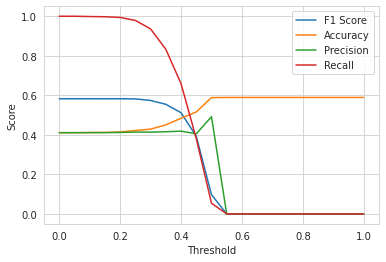

In [211]:
import matplotlib.pyplot as plt
import seaborn as sns

# initialize lists for storing results
f1_scores = []
acc_scores = []
prec_scores = []
rec_scores = []

# vary threshold and calculate scores
for THRES in np.arange(0, 1.05, 0.05):
    # calculate scores
    f1 = f1_score(y_true, np.where(y_pred > THRES, 1, 0), average='binary')
    acc = accuracy_score(y_true, np.where(y_pred > THRES, 1, 0))
    prec = precision_score(y_true, np.where(y_pred > THRES, 1, 0))
    rec = recall_score(y_true, np.where(y_pred > THRES, 1, 0))
    
    # store scores in lists
    f1_scores.append(f1)
    acc_scores.append(acc)
    prec_scores.append(prec)
    rec_scores.append(rec)

# plot results
sns.set_style("whitegrid")
plt.plot(np.arange(0, 1.05, 0.05), f1_scores, label='F1 Score')
plt.plot(np.arange(0, 1.05, 0.05), acc_scores, label='Accuracy')
plt.plot(np.arange(0, 1.05, 0.05), prec_scores, label='Precision')
plt.plot(np.arange(0, 1.05, 0.05), rec_scores, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()


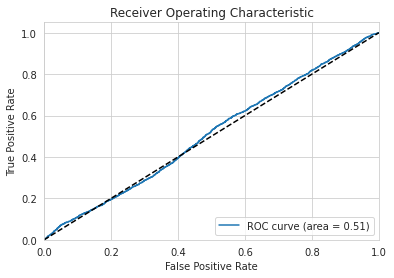

In [212]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# calculate fpr and tpr for different thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# calculate AUC
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


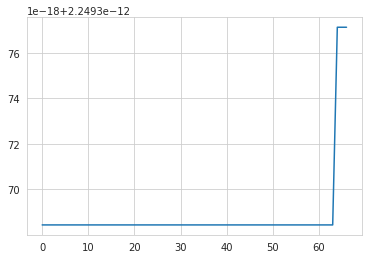

In [153]:
import matplotlib.pyplot as plt
plt.plot(outputs.detach().numpy())

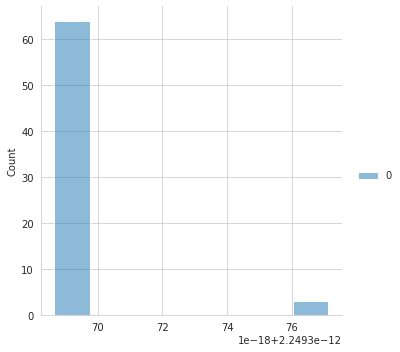

In [156]:
sns.displot(outputs.detach().numpy())

In [ ]:
THRESHOLD = 0.027

total_secs = 0

for i, y_p in enumerate(outputs.detach().numpy()):
    #print(i, y_p)
    if y_p >= THRESHOLD:
        print(i * SAMPLE_EVERY_SEC)
        total_secs += SAMPLE_EVERY_SEC

total_secs

In [ ]:
clip = VideoFileClip(video_path)

subclips = []

for i, y_p in enumerate(outputs.detach().numpy()):
    sec = i * SAMPLE_EVERY_SEC

    if y_p >= THRESHOLD:
        subclip = clip.subclip(sec, sec + SAMPLE_EVERY_SEC)
        subclips.append(subclip)

result = concatenate_videoclips(subclips)

result.write_videofile("videos/result.mp4")

result.ipython_display(width=640, maxduration=240)

# model evaluation

In [ ]:
def evaluate(y_true, y_pred):
    tp = ((y_true == 1) & (y_pred == 1)).sum()
    tn = ((y_true == 0) & (y_pred == 0)).sum()
    fp = ((y_true == 0) & (y_pred == 1)).sum()
    fn = ((y_true == 1) & (y_pred == 0)).sum()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    return f1_score, precision, recall

In [ ]:
## 새로운 데이터로 evaluation  